In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/reward_scaling/agents')

100%|██████████| 320/320 [00:32<00:00,  9.83it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
nadv = r.df('normalized_advantage')
nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      'norm_rewards': ['none', 'returns'],
}

NUM_BINS = 20

In [5]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
constraints = constraints.merge(key_metadata, on='exp_id')
constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

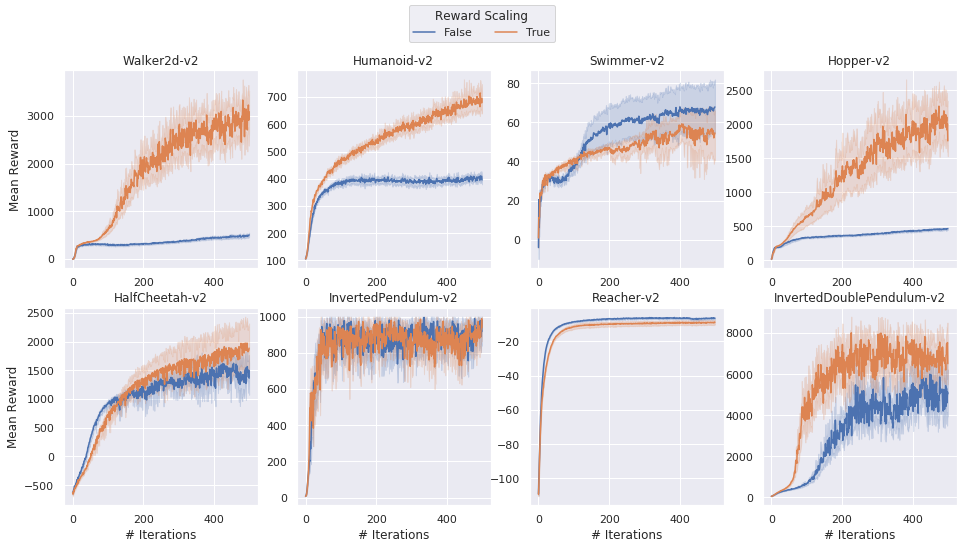

In [6]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    cl_opt = 'norm_rewards'
    for b in ['none', 'returns']:
        filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
        sns.lineplot(filt.opt_step, filt.mean_reward, n_boot=1000,
                     ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
    ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
for row in ax:
    row[0].set_ylabel('Mean Reward')
for a in ax[-1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, ['False', 'True'], loc='upper center', title='Reward Scaling', ncol=2)
plt.show()

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_nadv(exp_ids, min_step=0, max_step=500):
    aggregate_approx_nadv = []
    for exp_id in exp_ids:
        path = '../src/reward_scaling/agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, size_guidance={
            'histograms': 0, # store everything
        })
        event_acc.Reload()
        histograms = event_acc.Histograms('normalized_advantages')
        for h in histograms:
            if h.step < min_step or h.step > max_step:
                continue
            bucket_limit = np.array(h.histogram_value.bucket_limit)
            bucket_counts = np.array(h.histogram_value.bucket).astype(np.int)
            aggregate_approx_nadv.append(np.repeat(bucket_limit, bucket_counts))
    return np.array(aggregate_approx_nadv)

def show_histogram(exp_ids, ax, label='', min_step=0, max_step=500):
    aggregate_approx_nadv = extract_nadv(exp_ids, min_step, max_step)
    sns.distplot(aggregate_approx_nadv.flatten(), ax=ax, label=label)

In [11]:
exp_id_lookup = key_metadata.groupby(
    ['game', 'norm_rewards'])['exp_id'].apply(list)

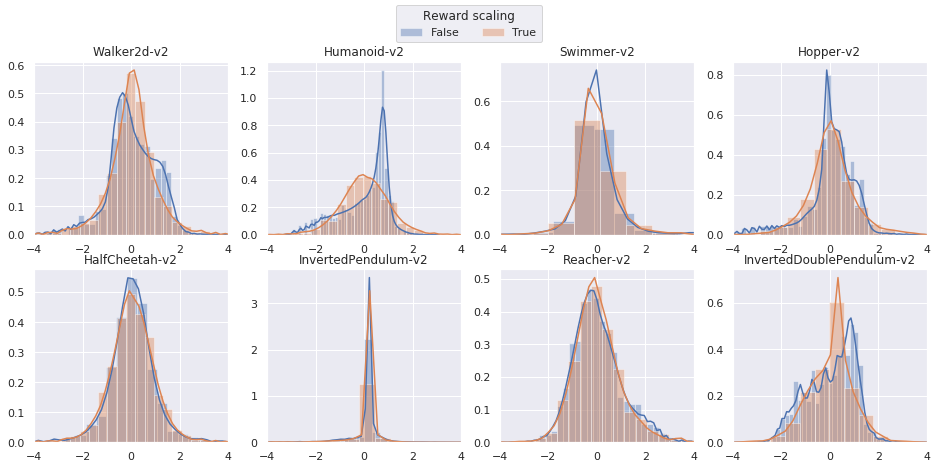

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in ['none', 'returns']:
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=0, max_step=100)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.suptitle('Distribution of normalized advantages, training steps 0 - 100')
fig.legend(handles, ['False', 'True'], loc='upper center', title='Reward scaling', ncol=3)
plt.show()

In [50]:
filt_data=nadv[(nadv.norm_rewards == 'returns')]
filt_data['game'] = filt_data['game'].apply(lambda name: name.strip('-v2'))
stats = filt_data.groupby('game').mean()[['skewness','kurtosis']]
stats_std = filt_data[['game','skewness','kurtosis']].groupby('game').std()
stats['skewness'] = stats['skewness'].round(1).astype(str).str.cat(
    stats_std['skewness'].round(1).astype(str), sep=r' $\pm$ ')
stats['kurtosis'] = stats['kurtosis'].round(1).astype(str).str.cat(
    stats_std['kurtosis'].round(1).astype(str), sep=r' $\pm$ ')
stats['min value'] = filt_data.groupby('game').min()[['min']].round(1)
stats['max value'] = filt_data.groupby('game').max()[['max']].round(1)

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
stats

,skewness,kurtosis,min value,max value
game,,,,
HalfCheetah,-4.6 $\pm$ 2.4,37.1 $\pm$ 18.1,-12.4,7.5
Hopper,-2.3 $\pm$ 3.6,27.5 $\pm$ 35.6,-15.3,12.2
Humanoid,-0.4 $\pm$ 0.5,4.7 $\pm$ 2.1,-9.9,10.5
InvertedDoublePendulum,-4.7 $\pm$ 2.7,38.2 $\pm$ 21.9,-14.1,19.1
InvertedPendulum,-6.6 $\pm$ 1.7,54.7 $\pm$ 13.5,-13.2,19.3
Reacher,0.7 $\pm$ 1.0,8.9 $\pm$ 6.2,-14.2,18.2
Swimmer,0.4 $\pm$ 5.4,69.2 $\pm$ 90.3,-30.1,38.3
Walker2d,-2.6 $\pm$ 3.0,26.1 $\pm$ 28.9,-15.3,13.6


In [52]:
print(stats.to_latex(escape=False))

\begin{tabular}{lllrr}
\toprule
{} &        skewness &         kurtosis &  min value &  max value \\
game                   &                 &                  &            &            \\
\midrule
HalfCheetah            &  -4.6 $\pm$ 2.4 &  37.1 $\pm$ 18.1 &      -12.4 &        7.5 \\
Hopper                 &  -2.3 $\pm$ 3.6 &  27.5 $\pm$ 35.6 &      -15.3 &       12.2 \\
Humanoid               &  -0.4 $\pm$ 0.5 &    4.7 $\pm$ 2.1 &       -9.9 &       10.5 \\
InvertedDoublePendulum &  -4.7 $\pm$ 2.7 &  38.2 $\pm$ 21.9 &      -14.1 &       19.1 \\
InvertedPendulum       &  -6.6 $\pm$ 1.7 &  54.7 $\pm$ 13.5 &      -13.2 &       19.3 \\
Reacher                &   0.7 $\pm$ 1.0 &    8.9 $\pm$ 6.2 &      -14.2 &       18.2 \\
Swimmer                &   0.4 $\pm$ 5.4 &  69.2 $\pm$ 90.3 &      -30.1 &       38.3 \\
Walker2d               &  -2.6 $\pm$ 3.0 &  26.1 $\pm$ 28.9 &      -15.3 &       13.6 \\
\bottomrule
\end{tabular}



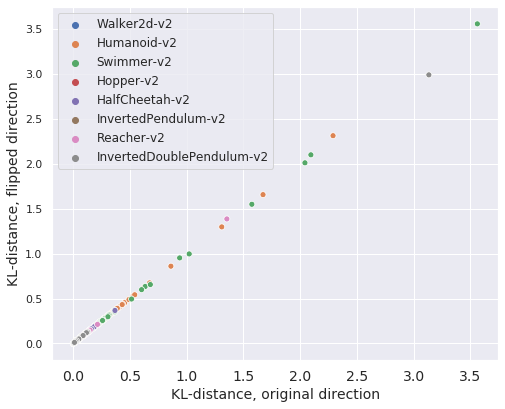

In [11]:
fig = plt.figure(figsize=(8, 6.5))
ax = sns.scatterplot(x='avg_kl_old_to_new', y='avg_kl_new_to_old',
                     data=constraints_heldout[
                             constraints_heldout.norm_rewards == 'returns'],
                     hue='game')
ax.set_xlabel('KL-distance, original direction', fontname='sans-serif', fontsize=14)
ax.set_ylabel('KL-distance, flipped direction', fontname='sans-serif', fontsize=14)
ax.legend().remove()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
#plt.legend(ncol=1, loc='upper left')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='upper left', ncol=1, fontsize=12)
#ax.set_ylim([0,1])
#ax.set_xlim([0,1])
plt.show()